In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.integrate import solve_ivp

For the ordered pairs $(a_0,a_1), (a_1,a_2), (a_2,a_3),(a_3,a_4)$ with $0 = a_0 \leq a_1 \leq a_2 \leq a_3 \leq a_4$, 
we define each $n_i$ to be the number of people between the ages of $a_{i-1}$ and $a_i$.

Our system of equations to model population change is the following:
$$\dot n_1(t) = \delta_0 n_2(t) -\delta_1 n_1(t)$$
$$\dot n_2(t) = \delta_1 n_1(t) - \delta_2 n_2(t)$$
$$\dot n_3(t) = \delta_2 n_2(t) - \delta_3 n_3(t)$$
$$\dot n_4(t) = \delta_3 n_3(t) - \delta_4 n_4(t)$$

Where $\delta_0 = \frac {b} {2(a_1 - a_0)}$ with birthrate $b$ and $\delta_i = \frac {1}{a_i-a_{i-1}}$


In [2]:
def get_deltas(age_brackets=[18, 40, 65, 85]):
    """
    Helper function that calculates and returns a list of deltas based on birthrate and age brackets.

    Parameters:
    - age_brackets (list): A list of age brackets defining the population segments.

    Returns:
    - list: A list of deltas calculated based on the given birthrate and age brackets.
    """

    # Insert 0 at the beginning of age_brackets to simplify calculations
    M = [0] + age_brackets

    # Calculate deltas based on age brackets
    deltas = [1 / (M[i] - M[i - 1]) for i in range(1, len(M))]

    # This is the births delta
    deltas = [.5/(M[2]-M[1])]+deltas

    # Return the modified delta list
    return deltas


In [3]:
def population_SIR(deltas,fertility_rate = 2):
    """
    Creates a function representing the population dynamics in an SIR (Susceptible-Infectious-Recovered) model.

    Parameters:
    - deltas (list or array): A list or array containing the transition rates between different population compartments.
    - birthrate (int or float or function) The birthrate for the country. Can be constant or a function of time.

    Returns:
    - function: A function representing the population dynamics in the SIR model.
    """

    # Convert deltas to a NumPy array for numerical operations
    d = np.array(deltas)

    def ode(t, n):
        """
        Function representing the rate of change of each population compartment in the SIR model.

        Parameters:
        - t (float): Time parameter (not used in the function, but required for integration).
        - n (array): Array representing the current state of the population compartments.

        Returns:
        - array: Array representing the rate of change of each population compartment.
        """
        DN = np.zeros_like(n)

        # Calculate the rate of change for each compartment based on the SIR model equations
        if callable(fertility_rate):
            DN[0] = fertility_rate(t)*d[0] * n[1] - d[1] * n[0]
        else:
            DN[0] = fertility_rate*d[0] * n[1] - d[1] * n[0]
        DN[1:] = -d[2:] * n[1:] + d[1:-1] * n[:-1]

        return DN
    
    # Return the function representing the population dynamics
    return ode

        

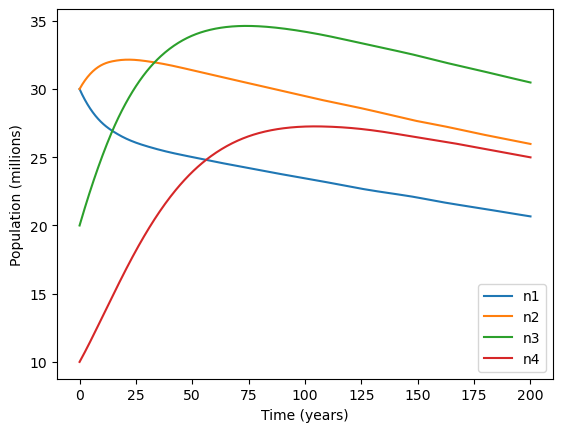

In [4]:
deltas = get_deltas()
ode = population_SIR(deltas,1.9)

ts = np.linspace(0,200,512)
x0 = np.array([30,30,20,10])

sol =solve_ivp(ode,(0,200),x0,t_eval=ts)

plt.plot(sol.t,sol.y.T,label = ["n1","n2","n3","n4"])
plt.legend()
plt.xlabel("Time (years)")
plt.ylabel("Population (millions)")
plt.show()


In [5]:
%store get_deltas
%store population_SIR
%store sol

Proper storage of interactively declared classes (or instances
of those classes) is not possible! Only instances
of classes in real modules on file system can be %store'd.

Proper storage of interactively declared classes (or instances
of those classes) is not possible! Only instances
of classes in real modules on file system can be %store'd.

Stored 'sol' (OdeResult)


### Granular population model variant
Although the previous 4 stage model was useful to understand the behavior of population growth, here we consider a more granular system that employs intervals of 1 years. We will abstract by not counting people who live beyond the 'life expectancy' or people who die ahead of time. Since our main goal is to observe the general relationship between young, working-age, and elderly, we will think these simplifications will be adequate.
We then use the following equations:
$$\dot n_0 = \frac {1} {2} r_f \sum_{i = 20}^{40} \frac{n_i}{20} - n_0$$
$$\dot n_i = n_{i-1} - n_i, \ \forall i \in \{1,2,...,k\}$$
Where $r_f$ is the fertility rate and $k$ is the 'life expectancy'.


In the following class, we attempt to implement the more robust solow growth model with our population model.

In [6]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.integrate import solve_ivp

class Solow_Model_Parameters():
    """This class holds the parameters for the Solow Growth Model."""
    
    def __init__(self, A=1, alpha=0.5, delta=0.08, s=0.3, weights=lambda x: (x >= 18) * (x <= 65)):
        """
        Initializes the parameters for the Solow Growth Model.
        
        Parameters:
        - A: Total factor productivity (Number or function with respect to time)
        - alpha: Output elasticity of capital
        - delta: Depreciation rate
        - s: Savings rate  (Number or function with respect to time)
        - weights: Function defining the age distribution weights
        """
        self.A = A
        self.alpha = alpha
        self.delta = delta
        self.s = s
        self.weights = weights
    
    def y(self, k, t, n=None):
        """
        Computes output (Y) given the capital (K), time (t), and labor (N).
        
        Parameters:
        - k: Capital
        - t: Time
        - n: Labor (optional). Proportion of the total population that is considered the labor force OR can be used to incorporate probability levels
        
        Returns:
        - Output (Y)
        """
        if callable(self.A):
            A = self.A(t)
        else:
            A = self.A
        if n is None:
            return A * k ** self.alpha
        else:
            return A * k ** self.alpha * n
    
    def kprime(self, k, dpop, pop, start_working, retire, t):
        """
        Computes the change in capital (K') given the capital (K), population change (dpop),
        total population (pop), start_working age, retire age, and time (t).
        
        Parameters:
        - k: Capital
        - dpop: Change in population
        - pop: Total population
        - start_working: Starting age of the workforce
        - retire: Retirement age
        - t: Time
        
        Returns:
        - Change in capital (K')
        """
        if callable(self.s):
            s = self.s(t)
        else:
            s = self.s
        n = (dpop[start_working] - dpop[retire + 1]) / np.sum(pop[start_working:retire + 1])
        return s * self.y(k, t,np.sum(pop[start_working:retire+1],axis =0)/np.sum(pop,axis = 0)) - (self.delta + n) * k

class Solution():
    """This class holds results from the Ordinary Differential Equation (ODE) solution."""
    
    def __init__(self, t, population, capital=None, y=None):
        """
        Initializes the solution results for the ODE.
        
        Parameters:
        - t: Time
        - population: Total population
        - capital: Capital (optional)
        - y: Output (Y) (optional)
        """
        self.t = t
        self.population = population
        self.capital = capital
        self.y = y


In [7]:
import numpy as np
from scipy.integrate import solve_ivp

class Population_Solow_Model():
    def __init__(self, life_expectancy=85, fertility_rate=2.0, fertility_starts=18, fertility_ends=40, solow_growth_parameters=None):
        """
        Initializes the Population Solow Model with parameters.
        
        Parameters:
        - life_expectancy: The average life expectancy in the model. Must be an integer and at least 40. Default is 85.
        - fertility_rate: A constant fertility rate or a function of time. Default is 2.0.
        - fertility_starts: The age at which fertility begins. Default is 18.
        - fertility_ends: The age at which fertility ends. Default is 40.
        - solow_growth_parameters: Parameters for the Solow Growth Model. Default is None.
        """
        self.fertility_rate = fertility_rate
        
        # Validate input types
        if not isinstance(life_expectancy, int):
            raise TypeError("'life_expectancy' must be an integer in this model.")
        self.life_expectancy = life_expectancy

        if not isinstance(fertility_starts, int):
            raise TypeError("'fertility_starts' must be an integer in this model.")
        self.fertility_starts = fertility_starts

        if not isinstance(fertility_ends, int):
            raise TypeError("'fertility_ends' must be an integer in this model.")
        self.fertility_ends = fertility_ends

        self.ode = None
        self.labels = None
        self.start_working = None
        self.retire = None
        self.SGP = solow_growth_parameters
        self.include_SGP = False
        return
    
    def prep_model(self, start_working=18, retire=65):
        """
        Prepares the population model based on the SIR framework with granular fertility.

        Parameters:
        - start_working: The age at which individuals start working. Default is 18.
        - retire: The retirement age. Default is 65.

        Returns:
        - self: The Population Solow Model instance with prepared settings.
        
        Raises:
        - TypeError: If life_expectancy is not an integer.
        - ValueError: If life_expectancy is less than 40.
        """
        # Validate life expectancy
        if not isinstance(self.life_expectancy, int):
            raise TypeError("Life expectancy must be an integer in this model.")
        elif self.life_expectancy < 40:
            raise ValueError("This model requires life_expectancy to be at least 40.")

        self.include_SGP = self.SGP is not None
        
        # Define the ordinary differential equation (ODE)
        def ode(t, x):
            """
            Ordinary differential equation representing the SIR population dynamics with granular fertility.

            Parameters:
            - t: Time variable.
            - x: Array representing the state variables, where x[i] represents the number of people at age i.

            Returns:
            - dx: Array representing the rates of change of the state variables.
            """
            dx = np.zeros_like(x)

            # Calculate the births based on the fertility rate
            if callable(self.fertility_rate):
                dx[0] = 0.5 * self.fertility_rate(t) * np.mean(x[self.fertility_starts:self.fertility_ends + 1]) - x[0]
            else:
                dx[0] = 0.5 * self.fertility_rate * np.mean(x[self.fertility_starts:self.fertility_ends + 1]) - x[0]

            # Calculate the change in other age categories
            dx[1:] = x[:-1] - x[1:]

            # Add the capital allocation variables if necessary
            if self.include_SGP:
                dx[-1] = self.SGP.kprime(x[-1], dx[:-1], x[:-1], start_working, retire, t)

            return dx

        # Set attributes for the model
        self.ode = ode
        self.labels = [f"{i}-{i+1}" for i in range(self.life_expectancy)]
        self.start_working = start_working
        self.retire = retire
        return self
    
    def solve(self, t_points, starting_population, starting_capital=None):
        """
        Solves the ODE for population dynamics given initial conditions.

        Parameters:
        - t_points: Time points to solve the ODE.
        - starting_population: Initial population distribution across age categories.
        - starting_capital: Initial capital (if Solow Growth Parameters are included).

        Returns:
        - Solution: Instance of the Solution class containing the ODE results.
        
        Raises:
        - AssertionError: If Population_Solow_Model().ode is not defined.
        """
        if self.ode is None:
            raise AssertionError("'Population_Solow_Model().ode' has not been defined. Run 'Population_Solow_Model().create_model' first.")

        # Prepare initial state
        if not self.include_SGP:
            x = starting_population
        else:
            x = np.concatenate([starting_population, np.array([starting_capital])])

        t_span = (np.min(t_points), np.max(t_points))
        
        # Solve the ODE
        sol = solve_ivp(self.ode, t_span, x, t_eval=t_points)

        if self.SGP is None:
            return Solution(sol.t, sol.y)
        else:
            # Calculate labor and return Solution instance
            n = np.sum(sol.y[:-1] * np.reshape(self.SGP.weights(np.arange(self.life_expectancy)), (-1, 1)), axis=0) / np.sum(sol.y[:-1], axis=0)
            return Solution(sol.t, sol.y[:-1], sol.y[-1], self.SGP.y(sol.y[-1], ts, n))


In [8]:
def consolidate_age_groups(x,age_brackets = [18,40,65],return_labels = False):
    age_brackets.sort()
    M = [0]+age_brackets + [len(x)]
    ns = np.array([np.sum(x[M[i]:M[i+1]],axis = 0)for i in range(len(M)-1)])
    if return_labels:
        labels = [f"{M[i]}-{M[i+1]}" for i in range(len(M)-1)]
        return ns,labels
    else:
        return ns



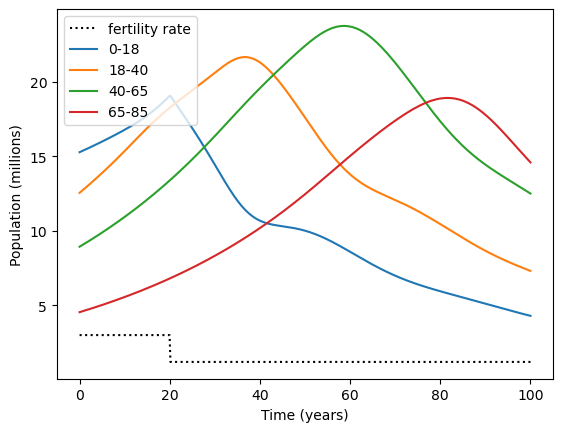

In [9]:
life_expect = 85
def fertility_rate(t):
    #Either a constant, or a function with respect to time
    return 1.2 + 1.8*(t<=20)
# Here we initialize the ode function to solve
population_model = Population_Solow_Model(fertility_rate=fertility_rate,life_expectancy=life_expect)

ts = np.linspace(0,100,512)
# Here we set the initial population
x0 = np.exp(-.02*np.arange(life_expect))

population_model.prep_model()
sol = population_model.solve(ts,x0,2)


# Here consolidate the ages into age brackets, to make the data more visible
# Grouping the age brackets will also make it easier for our model
values,labels = consolidate_age_groups(sol.population,return_labels=True)

# Here we plot the results
plt.plot(sol.t,fertility_rate(sol.t),":k",label = "fertility rate")
plt.plot(sol.t,values.T,label = labels)
plt.legend()
plt.xlabel("Time (years)")
plt.ylabel("Population (millions)")
plt.show()


Note that this model handles population shocks far better than the previous one because it better demonstrates the lag of a sudden drop in birthrate.


#### Now we look at a sudden population boom:

With capital this time as well.


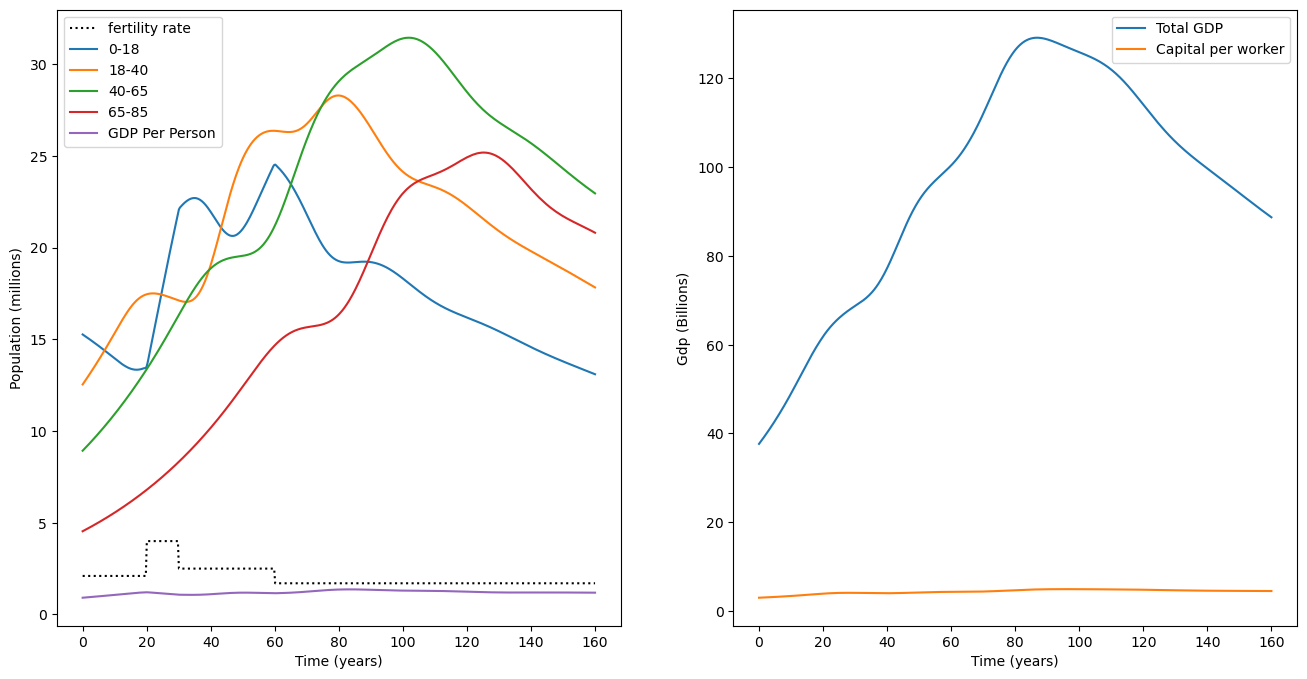

In [10]:
life_expect = 85
def fertility_rate(t):
    #Either a constant, or a function with respect to time
    return 2.1 + 1.9*(t>=20)-1.5*(t>=30) - .8*(t>=60)

solow_parameters = Solow_Model_Parameters()
# Here we initialize the ode function to solve
population_model = Population_Solow_Model(fertility_rate=fertility_rate,life_expectancy=life_expect,solow_growth_parameters=solow_parameters)

ts = np.linspace(0,160,512)
# Here we set the initial population
x0 = np.exp(-.02*np.arange(life_expect))

population_model.prep_model()
sol = population_model.solve(ts,x0,3)
# Here consolidate the ages into age brackets, to make the data more visible
# Grouping the age brackets will also make it easier for our model
values,labels = consolidate_age_groups(sol.population,return_labels=True)

# Here we plot the results
print("With capital this time as well.")
plt.figure(figsize=(16,8))
plt.subplot(121)
plt.plot(sol.t,fertility_rate(sol.t),":k",label = "fertility rate")
plt.plot(sol.t,values.T,label = labels)
plt.plot(sol.t,sol.y,label = "GDP Per Person")
plt.legend()
plt.xlabel("Time (years)")
plt.ylabel("Population (millions)")

plt.subplot(122)
plt.xlabel("Time (years)")
plt.ylabel("Gdp (Billions)")

plt.plot(sol.t,sol.y*np.sum(sol.population,axis = 0),label = "Total GDP")
plt.plot(sol.t, sol.capital,label = "Capital per worker")
plt.legend()
plt.show()
